### Урок 5. Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Практика

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
#from sklearn.feature_extraction.text import TfidfVectorizer

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

# StandardScaler() - https://stackoverflow.com/questions/51459406/how-to-apply-standardscaler-in-pipeline-in-scikit-learn-sklearn
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [9]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [10]:
pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42)),
])

pipeline_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [11]:
params_rf = dict(classifier__n_estimators=[200, 500, 800],
                 classifier__max_depth=[6, 8, 12])
params_logreg = dict(classifier__C=[0.5, 1, 10, 100])
params_xgb = dict(classifier__n_estimators=[100, 200, 300],
                 classifier__max_depth=[2, 3, 4, 6])

Масштабируем данные для логистической регрессии

In [12]:
scaler_std = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm[continuous_columns] = scaler_std.fit_transform(X_train_norm[continuous_columns])
X_test_norm[continuous_columns] = scaler_std.transform(X_test_norm[continuous_columns])

Объединим поиск параметров и кросс-валидацию.

In [13]:
def find_parameters(pipe, params, X_train, y_train):
    
    rs = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=5)  # Тут же делаем кросс-валидацию
    rs.fit(X_train, y_train.values.ravel())
    
    print(f"Model: {pipe['classifier']},\n params: {rs.best_params_},\n best_score: {rs.best_score_}\n\n")

In [14]:
%%time
find_parameters(pipeline_rf, params_rf, X_train, y_train)

Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False),
 params: {'classifier__max_depth': 12, 'classifier__n_estimators': 500},
 best_score: 0.8556638411923645


Wall time: 1min 49s


In [15]:
%%time
find_parameters(pipeline_logreg, params_logreg, X_train_norm, y_train)

Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False),
 params: {'classifier__C': 0.5},
 best_score: 0.7609850300706006


Wall time: 1.43 s


In [16]:
%%time
find_parameters(pipeline_xgb, params_xgb, X_train, y_train)

Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=42, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None),
 params: {'classifier__max_depth': 2, 'classifier__n_estimators': 100},
 best_score: 0.85939488363985


Wall time: 1min 15s


In [18]:
pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=12, n_estimators=500, random_state=42)),
])

pipeline_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(max_depth=2, n_estimators=100, random_state=42)),
])

pipeline_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=0.5, random_state=42)),
])

In [19]:
%%time

#обучим пайплайн на всем тренировочном датасете
def fit_predict_models(pipe, X_train, y_train, X_test):
    pipe.fit(X_train, y_train)
    y_score = pipe.predict_proba(X_test)[:, 1]
    return y_score

y_score_logreg = fit_predict_models(pipeline_logreg, X_train_norm, y_train, X_test_norm)
y_score_xgb = fit_predict_models(pipeline_xgb, X_train, y_train, X_test)
y_score_rf = fit_predict_models(pipeline_rf, X_train, y_train, X_test)

Wall time: 3.65 s


В задаче оттока, мне кажется, наиболее актуальные метрики - precision или fscore. Precision - обеспечит максимальное содержание TP в предсказаниях модели, а значит мы не будем тратить неэффективно бюджет на FP. С другой стороны, fscore позволит выдержать баланс между метриками, но я бы взял её опять же с корректировкой на precision. 

In [20]:
def metrics_calculation(y_test, preds, b=1):

    roc_auc = roc_auc_score(y_test, preds)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [21]:
all_preds = [y_score_logreg, y_score_xgb, y_score_rf]
metrics = []
for preds in all_preds:
    best_threshold, fscore, precision, recall, roc_auc = metrics_calculation(y_test, preds, b=0.7)  # приоретизируем precision
    metrics.append([best_threshold, fscore, precision, recall, roc_auc])
metrics = np.array(metrics)

c:\users\orlov\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [22]:
# В одном из случаев логистическая регрессия на столько плоха, что выдаёт TP = o из-за этого получается ошибка выше и как результат fscore == NaN
# Чтобы избежать этого использовал np.nanargmax() - метод выбирает индекс максимального не NaN элемента
# https://stackoverflow.com/questions/2821072/is-there-a-better-way-of-making-numpy-argmin-ignore-nan-values
#y_score_logreg_bin = [1 if i>metrics[0, 0] else 0 for i in y_score_logreg]
#confusion_matrix(y_test, y_score_logreg_bin)

In [23]:
metrics_comparison_df = pd.DataFrame(np.array(metrics[:, 1:]),
                   columns=['fscore', 'precision', 'recall', 'roc_auc'],
                   index=['y_score_logreg', 'y_score_xgb', 'y_score_rf'])
metrics_comparison_df

,fscore,precision,recall,roc_auc
y_score_logreg,0.499123,0.513100,0.472837,0.773439
y_score_xgb,0.654418,0.742210,0.527163,0.866775
y_score_rf,0.659808,0.725131,0.557344,0.865946


In [24]:
xhb_threshold = metrics[1, 0]  # запишем оптимальный порог для построения confusion_matrix

Отрисуем матрицу ошибок

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1912   91]
 [ 236  261]]


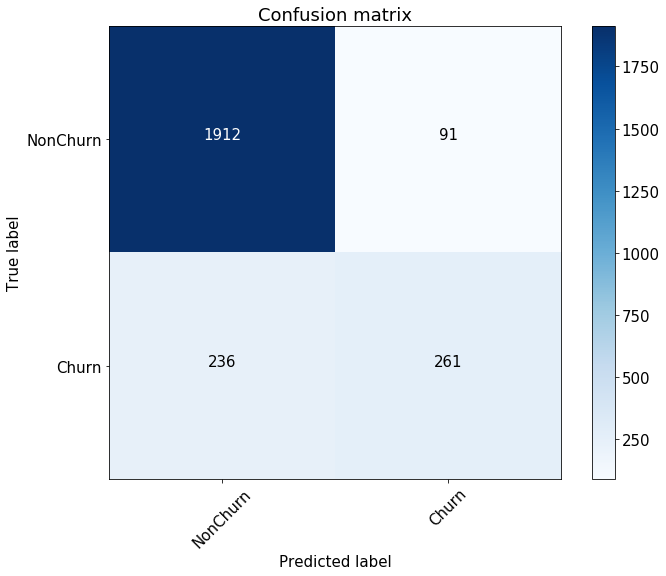

In [26]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score_xgb>xhb_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Из матрицы получаем значения:
* TP - 261
* FP - 91
* TN - 1912
* FN - 236

**Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?**

На удержание мы потратим 1 USD * (261 (TP) + 91 (FP)) = 352 USD, а заработаем 261 * 2 USD = 522 USD. Итого мат. ожидание модели 522 USD - 352 USD = +170 USD.